### This notebook is a tutorial for the PERT infer scRT module.

PERT takes binned read counts with called copy number states as input from scWGS. Cells are split into high-confidence G1/2-phase and unknown phase sets of cells before passing data into the probabilistic model.

Here, we are analyzing simulated data from 400 S-phase cells and 400 G1-phase cells with no CNAs. HMMcopy has been run on the simulated data to obtain the `copy` and `state` columns.

In [1]:
%%capture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scdna_replication_tools.infer_scRT import scRT
from scdna_replication_tools.plot_pert_output import plot_model_results

In [2]:
# load the simulated data from the paper
# this corresponds to the data seen in simulated dataset 1.0
cn_s = pd.read_csv('data/D1.0/s_phase_cells_hmmcopy.csv.gz')
cn_g1 = pd.read_csv('data/D1.0/g1_phase_cells_hmmcopy.csv.gz')
cn_s.head()

,cell_id,chr,start,end,reads,gc,map,copy,state,multiplier,...,clone_cn_state,true_G1_state,library_id,true_reads_norm,true_reads_raw,true_rep,true_p_rep,true_t,observed_cn_state,true_cell_frac_rep
0,cell_S_0,1,2000000,2500000,428,0.594508,0.997066,1.690361,2,2,...,2.0,2.0,ABCD,228,428.0,0.0,0.525526,0.063202,2.0,0.083287
1,cell_S_0,1,4500000,5000000,357,0.481828,0.999002,1.900438,2,2,...,2.0,2.0,ABCD,190,357.0,0.0,0.001294,0.063202,2.0,0.083287
2,cell_S_0,1,6500000,7000000,389,0.489968,0.999179,2.027809,2,2,...,2.0,2.0,ABCD,207,389.0,0.0,0.399713,0.063202,2.0,0.083287
3,cell_S_0,1,7500000,8000000,395,0.488250,0.998566,2.068249,2,2,...,2.0,2.0,ABCD,211,395.0,0.0,0.198803,0.063202,2.0,0.083287
4,cell_S_0,1,8000000,8500000,337,0.462702,0.998576,1.883205,2,2,...,2.0,2.0,ABCD,180,337.0,0.0,0.265740,0.063202,2.0,0.083287


In [3]:
cn_g1.head()

,cell_id,chr,start,end,reads,gc,map,copy,state,multiplier,...,nhek_rt,bin_size,clone_id,clone_cn_state,true_G1_state,library_id,true_reads_norm,true_reads_raw,observed_cn_state,true_cell_frac_rep
0,cell_G_0,1,2000000,2500000,839,0.594508,0.997066,2.103612,2,2,...,72.161813,500000,A,2.0,2.0,ABCD,286,839.0,2.0,0.0
1,cell_G_0,1,4500000,5000000,594,0.481828,0.999002,1.897203,2,2,...,40.645100,500000,A,2.0,2.0,ABCD,202,594.0,2.0,0.0
2,cell_G_0,1,6500000,7000000,588,0.489968,0.999179,1.844981,2,2,...,67.336678,500000,A,2.0,2.0,ABCD,200,588.0,2.0,0.0
3,cell_G_0,1,7500000,8000000,632,0.488250,0.998566,1.990483,2,2,...,60.800801,500000,A,2.0,2.0,ABCD,215,632.0,2.0,0.0
4,cell_G_0,1,8000000,8500000,629,0.462702,0.998576,2.094786,2,2,...,70.025844,500000,A,2.0,2.0,ABCD,214,629.0,2.0,0.0


In [4]:
# add the replication columns for the G1-phase cells
cn_g1['true_rep'] = 0.0
cn_g1['true_p_rep'] = 0.0
cn_g1['true_t'] = 1.0

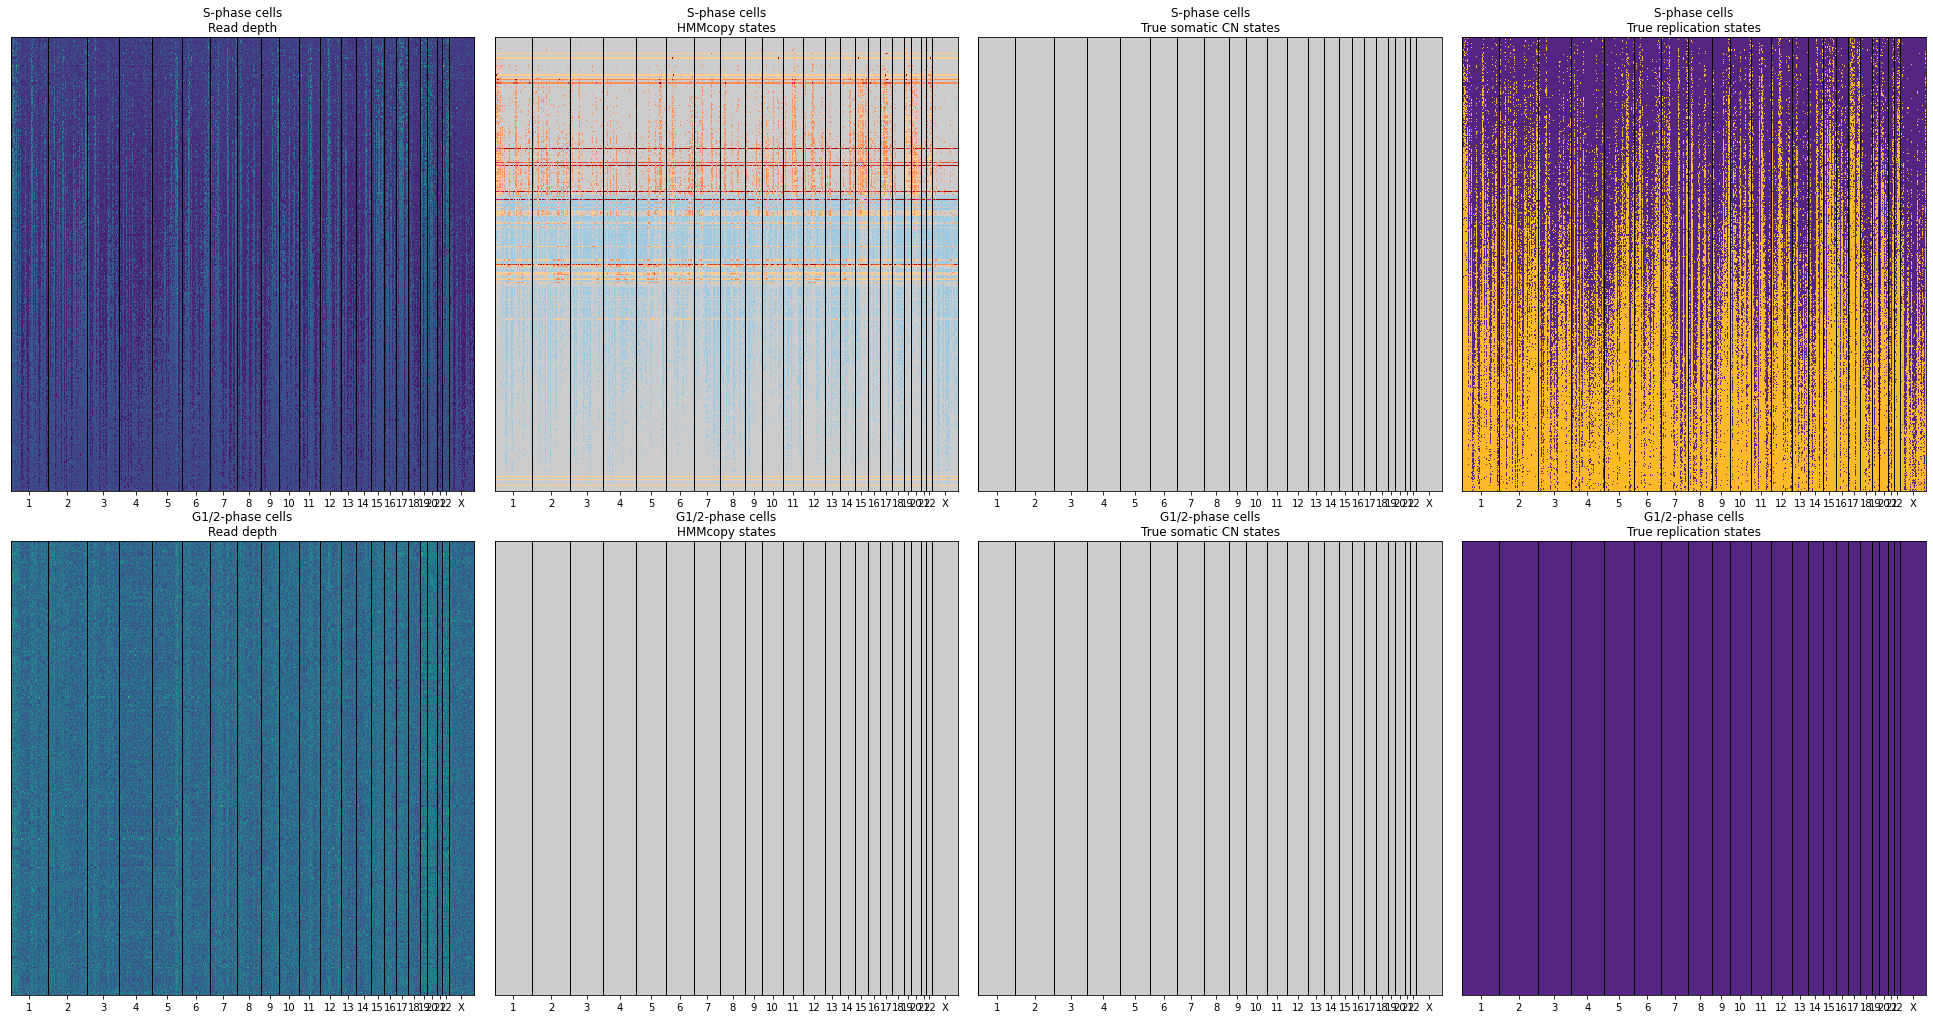

In [5]:
# plot the true simulated data
plot_model_results(
    cn_s, cn_g1, clone_col='clone_id', second_sort_col='true_t', 
    input_cn_col='state', output_cn_col='true_G1_state', 
    output_rep_col='true_rep', rpm_col='true_reads_norm',
    rpm_title='Read depth', input_cn_title='HMMcopy states',
    output_cn_title='True somatic CN states', rep_title='True replication states'
)
plt.show()

In the above plots, note how the HMMcopy `state` column accurately reflects somatic CN for G1/2-phase cells but not S-phase cells. This is because the HMMcopy model is not designed to handle the high copy number of S-phase cells. Given that replication origins are disproportionately located in high GC regions, some of the replication signal gets regressed out during per-cell GC normalization (1st step of hmmcopy). Thus, many replicated vs unreplicated bins in S-phase cells don't have clear 2:1 ratios, leading HMMcopy to select an erroneously high ploidy multiplier (2nd step of hmmcopy). Even if the ploidy multiplier is correct, the HMMcopy states only reflect the replicated signal that remains after GC normalization, so the states should be ignored in S-phase cells.

### Now we will run PERT to jointly infer scRT and CN states for all cells.

We are going to limit this example to just chromosomes 1-3 to speed up the analysis. We will also use a small number of iterations to speed up the analysis. In practice, we recommend using >1000 iterations and all chromosomes. One can also adjust the `learning_rate` and `rel_tol` away from default values of 0.05 and 1e-6, respectively, to achieve a desired optimization routine.

In [6]:
# temporarily remove columns that don't get used by PERT
temp_cn_s = cn_s[['cell_id', 'chr', 'start', 'end', 'gc', 'state', 'library_id', 'true_reads_norm']]
temp_cn_g1 = cn_g1[['cell_id', 'chr', 'start', 'end', 'gc', 'clone_id', 'state', 'library_id', 'true_reads_norm']]

# subset to only include chromosomes 1-3 for speed
temp_cn_s = temp_cn_s[(temp_cn_s['chr'] == '1') | (temp_cn_s['chr'] == '2') | (temp_cn_s['chr'] == '3')]
temp_cn_g1 = temp_cn_g1[(temp_cn_g1['chr'] == '1') | (temp_cn_g1['chr'] == '2') | (temp_cn_g1['chr'] == '3')]
print('number of cells in S-phase: ', len(temp_cn_s['cell_id'].unique()))
print('number of cells in G1-phase: ', len(temp_cn_g1['cell_id'].unique()))
print('number of loci in S-phase: ', len(temp_cn_s[['chr', 'start']].drop_duplicates()))
print('number of loci in G1-phase: ', len(temp_cn_g1[['chr', 'start']].drop_duplicates()))

number of cells in S-phase:  400
number of cells in G1-phase:  400
number of loci in S-phase:  752
number of loci in G1-phase:  752


In [7]:
%%capture

# create scRT object with input columns denoted
scrt = scRT(temp_cn_s, temp_cn_g1, input_col='true_reads_norm', clone_col='clone_id', assign_col='state', rt_prior_col=None,
            cn_state_col='state', gc_col='gc', cn_prior_method='g1_clones', max_iter=200)

# run inference using PERT
cn_s_with_scrt, supp_s_output, cn_g_with_scrt, supp_g_output = scrt.infer(level='pyro')

In [8]:
cn_s_with_scrt.head()

,cell_id,chr,start,end,gc,state,library_id,true_reads_norm,clone_id,model_cn_state,model_rep_state,model_tau,model_u,model_rho
0,cell_S_0,1,2000000,2500000,0.594508,2,ABCD,228,A,2,0.0,0.141440,73.521355,0.141027
1,cell_S_1,1,2000000,2500000,0.594508,2,ABCD,184,A,2,0.0,0.164261,78.228539,0.141027
2,cell_S_10,1,2000000,2500000,0.594508,3,ABCD,379,A,2,1.0,0.241355,69.192123,0.141027
3,cell_S_100,1,2000000,2500000,0.594508,2,ABCD,171,A,2,1.0,0.788927,45.628704,0.141027
4,cell_S_101,1,2000000,2500000,0.594508,2,ABCD,297,A,2,1.0,0.598919,47.823143,0.141027


In [9]:
cn_g_with_scrt.head()

,cell_id,chr,start,end,gc,clone_id,state,library_id,true_reads_norm,model_cn_state,model_rep_state,model_tau,model_u,model_rho
0,cell_G_0,1,2000000,2500000,0.594508,A,2,ABCD,286,2,0.0,0.055101,67.678299,0.141027
1,cell_G_1,1,2000000,2500000,0.594508,A,2,ABCD,247,5,1.0,0.921635,56.924030,0.141027
2,cell_G_10,1,2000000,2500000,0.594508,A,2,ABCD,244,2,0.0,0.064366,65.520317,0.141027
3,cell_G_100,1,2000000,2500000,0.594508,A,2,ABCD,254,2,0.0,0.046164,68.735535,0.141027
4,cell_G_101,1,2000000,2500000,0.594508,A,2,ABCD,233,2,0.0,0.072263,64.531784,0.141027


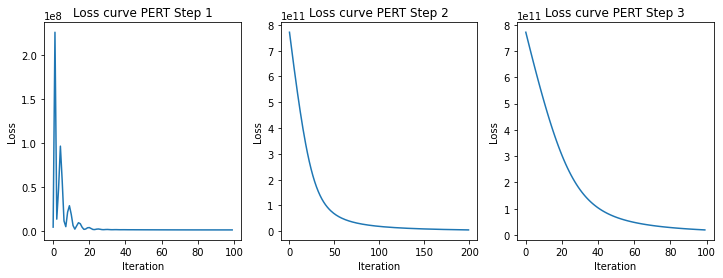

In [10]:
# plot the loss curve for 'loss_s' and 'loss_g' param values in the supp_s_output and supp_g_output dataframes
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.lineplot(data=supp_s_output.query("param=='loss_g'"), x='level', y='value', ax=ax[0])
sns.lineplot(data=supp_s_output.query("param=='loss_s'"), x='level', y='value', ax=ax[1])
sns.lineplot(data=supp_g_output.query("param=='loss_s'"), x='level', y='value', ax=ax[2])

for i in range(3):
    ax[i].set_xlabel('Iteration')
    ax[i].set_ylabel('Loss')
    ax[i].set_title('Loss curve PERT Step {}'.format(i+1))

plt.show()

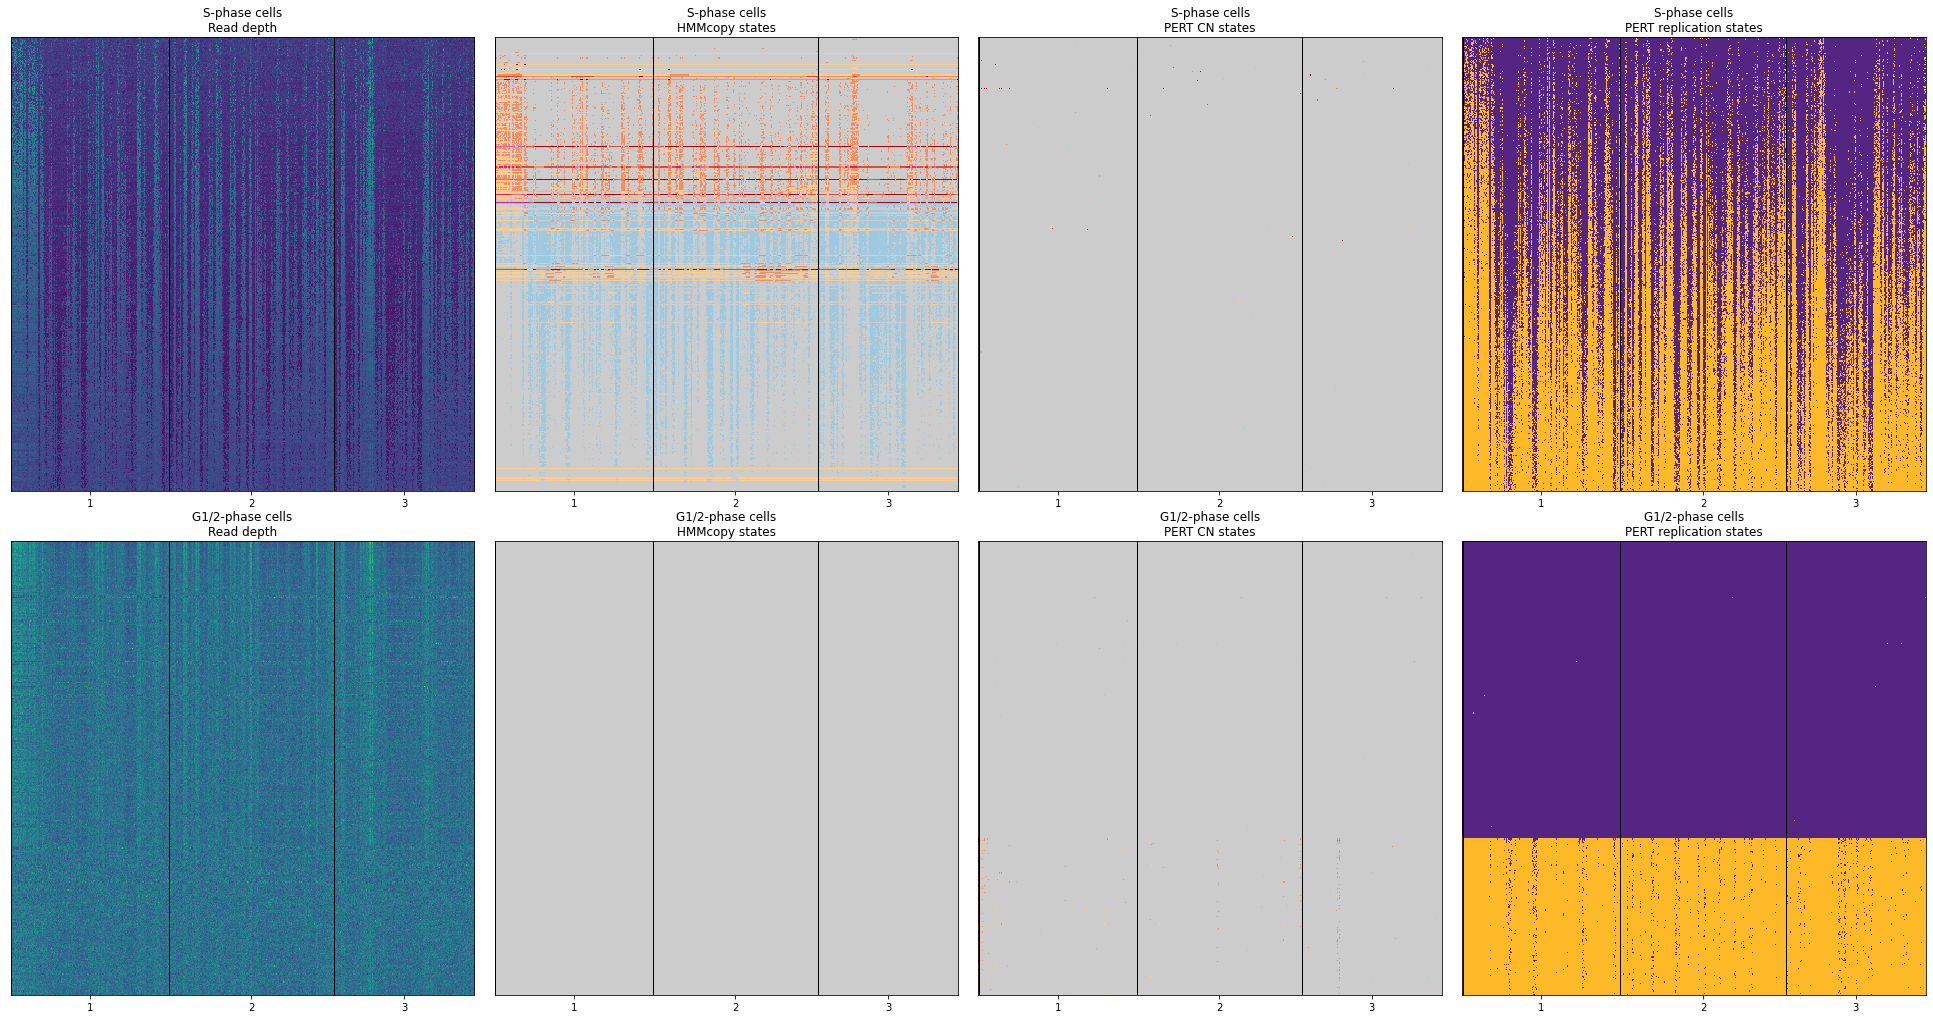

In [11]:
# plot the results of the inference
plot_model_results(
    cn_s_with_scrt, cn_g_with_scrt, clone_col='clone_id', second_sort_col='model_tau',
    input_cn_col='state', output_cn_col='model_cn_state', output_rep_col='model_rep_state',
    rpm_col='true_reads_norm', rpm_title='Read depth', input_cn_title='HMMcopy states',
    output_cn_title='PERT CN states', rep_title='PERT replication states'
)
plt.show()